In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm

In [3]:
dataloader = utils.MRIDataLoader()

In [4]:
subject_id_default = 0
mri_data = dataloader.get_img(subject_id_default, 'signal')
seg_data = dataloader.get_img(subject_id_default, 'seg')
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
thresh_default = 0.9

In [5]:
problem_one_compartment = utils.create_problem_to_minimize('one_compartment')
problem_two_compartment = utils.create_problem_to_minimize('two_compartment')
problem_two_v_compartment = utils.create_problem_to_minimize('two_compartment_v')

In [67]:
mri_data_flatten = mri_data.reshape(-1, mri_data.shape[-1])
seg_data_flatten = seg_data.reshape(-1, seg_data.shape[-1])

x0 = np.array([5000, 50, 60])
roi_answers = []
nb_roi_select_max = 1000

for roi_id in tqdm(roi_id_dict, ascii=True):
    roi = roi_id_dict[roi_id]
    print(f'Solving {roi}...')
    roi_data_total = mri_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    roi_seg_data_total = seg_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    nb_roi_total = roi_data_total.shape[0]
    nb_roi_select = min([nb_roi_total, nb_roi_select_max])
    
    roi_rand_ids = np.random.randint(low=0, high=nb_roi_total, size=nb_roi_select)
    roi_data = roi_data_total[roi_rand_ids]
    roi_seg_data = roi_seg_data_total[roi_rand_ids]
    
    print(f'{nb_roi_total} total voxels, calculating with {nb_roi_select} of them')
    
    X0 = np.tile(x0, reps=nb_roi_select).reshape(nb_roi_select, -1)
    args_TE = np.tile(TE_times, reps=nb_roi_select).reshape(nb_roi_select, -1)
    v0 = roi_seg_data[:,1:].max(axis=-1)
    v0 = np.where(v0 < 0.5, 0.5, v0)
    v = np.stack([v0, 1-v0], axis=-1)
    # args_10 = [roi_data, args_TE, v]
    args_9  = [roi_data[:,1:], args_TE[:,1:], v]    # missing out the first TE signal due to very low T2 value distorting signal
    # S0_10, T2_0_10, T2_1_10 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_10, is_print_progress=True)
    S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_9, is_print_progress=False)
    
    # T2_10 = np.stack([T2_0_10, T2_1_10], axis=-1)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    signal_est = utils.model_multi_compartment(T2, S0, TE_times, v)
    rmse = utils.RMSE(roi_data, signal_est, dim=-1)
    roi_answers.append([S0, T2, v, rmse])

  0%|          | 0/6 [00:00<?, ?it/s]

Solving brain...
63631 total voxels, calculating with 1000 of them


 17%|#6        | 1/6 [00:11<00:56, 11.32s/it]

Solving CSF...
8365 total voxels, calculating with 1000 of them


 33%|###3      | 2/6 [00:20<00:40, 10.06s/it]

Solving GM...
19063 total voxels, calculating with 1000 of them


 50%|#####     | 3/6 [00:31<00:31, 10.40s/it]

Solving WM...
13473 total voxels, calculating with 1000 of them


 67%|######6   | 4/6 [00:41<00:20, 10.24s/it]

Solving DeepGM...
1187 total voxels, calculating with 1000 of them


 83%|########3 | 5/6 [00:51<00:10, 10.09s/it]

Solving brainstem...
560 total voxels, calculating with 560 of them


100%|##########| 6/6 [00:56<00:00,  9.41s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


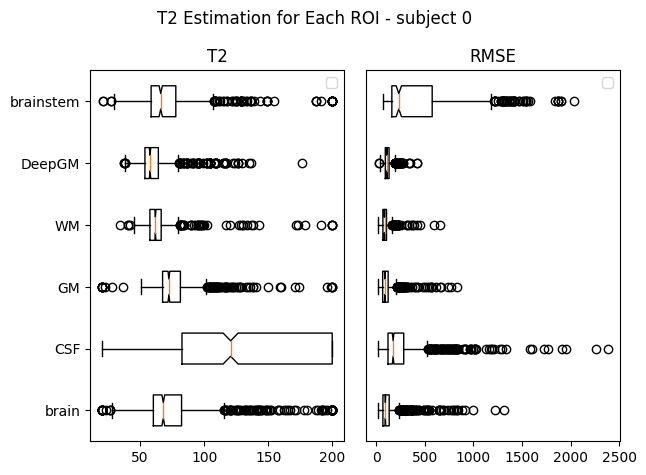

In [84]:
fig, axs = plt.subplots(1,2)
fig.suptitle(f'T2 Estimation for Each ROI - subject {subject_id_default}')

T2_list = []
rmse_list = []
labels = []

for roi_id in roi_id_dict:
    roi = roi_id_dict[roi_id]
    labels.append(roi)
    S0 = roi_answers[roi_id][0]
    T2 = roi_answers[roi_id][1]
    v = roi_answers[roi_id][2]
    rmse = roi_answers[roi_id][3]
    
    T2_list.append(T2[:,0])
    rmse_list.append(rmse)

axs[0].boxplot(T2_list, labels, vert=False)
axs[0].set_title('T2')
axs[0].set_yticklabels(labels)
axs[0].legend()

axs[1].boxplot(rmse_list, labels, vert=False)
axs[1].set_title('RMSE')
axs[1].set_yticks([])
axs[1].legend()


# axs[0].hist(T2_09[:,0], label='0.9', alpha=0.5, bins=30)
# axs[0].hist(T2_06[:,0], label='0.6', alpha=0.5, bins=30)
# axs[0].set_title('T2 for different thresh')
# axs[0].legend()

# axs[1].hist(T2_10[:,1], label='10', alpha=0.5)
# axs[1].hist(T2_9[:,1], label='9', alpha=0.5)
# axs[1].set_title('T2_1')
# axs[1].legend()

fig.tight_layout()

In [16]:
v[vox_id]

array([0.91440141, 0.08559859])

In [21]:
T2_09.shape

(1906, 2)

[0.92629486 0.07370514]
[47.28293441 40.        ]


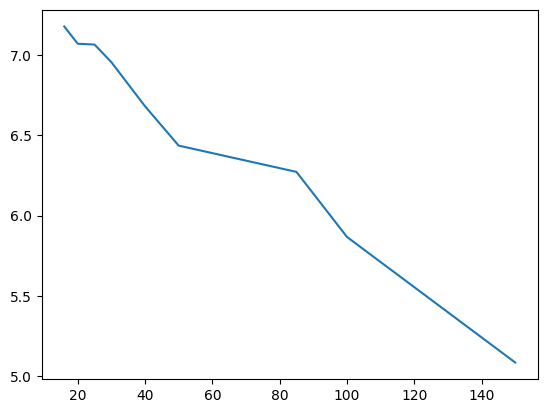

In [55]:
vox_id = 350
signal_actual = roi_data[vox_id]
signal_est = utils.model_multi_compartment(T2_06[vox_id], S0_9[vox_id], TE_times, v[vox_id])
print(v[vox_id])
print(T2_06[vox_id])

# plt.plot(TE_times, np.log(signal_actual), label='actual')
# plt.plot(TE_times, np.log(signal_est), label='actual')
plt.plot(TE_times[1:],  np.log(signal_actual[1:]))

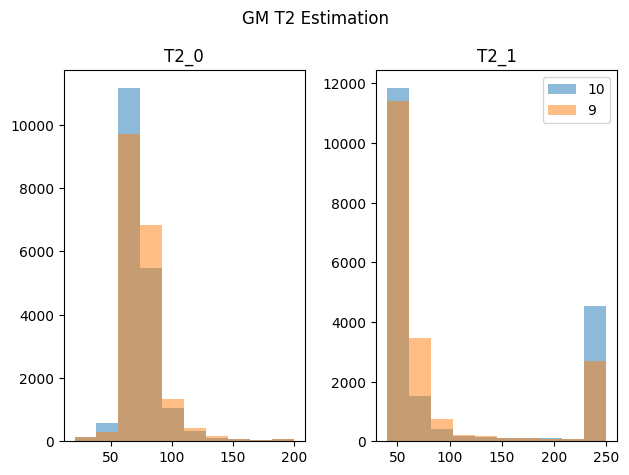

In [ ]:
fig, axs = plt.subplots(1,2)
fig.suptitle(f'{roi} T2 Estimation')

axs[0].hist(T2_10[:,0], label='10', alpha=0.5)
axs[0].hist(T2_9[:,0], label='9', alpha=0.5)
axs[0].set_title('T2_0')

axs[1].hist(T2_10[:,1], label='10', alpha=0.5)
axs[1].hist(T2_9[:,1], label='9', alpha=0.5)
axs[1].set_title('T2_1')
axs[1].legend()

fig.tight_layout()

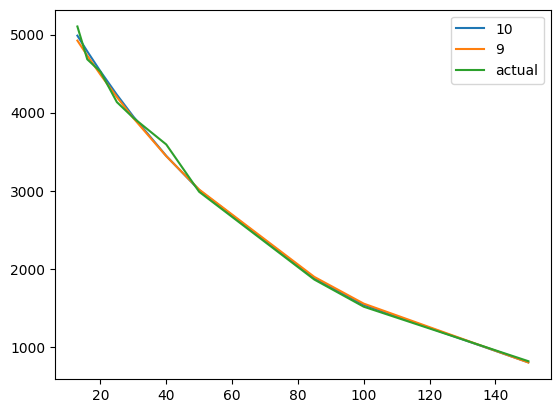

In [ ]:
vox_id = 462

signal_est_10 = utils.model_multi_compartment(T2_10[vox_id].reshape(1,2), S0_10[vox_id], TE_times, v[vox_id].reshape(1,2))
signal_est_9 = utils.model_multi_compartment(T2_9[vox_id].reshape(1,2), S0_9[vox_id], TE_times, v[vox_id].reshape(1,2))
signal = roi_data[vox_id]

plt.plot(TE_times, signal_est_10[0], label='10')
plt.plot(TE_times, signal_est_9[0], label='9')
plt.plot(TE_times, signal, label='actual')
plt.legend()
